In [3]:
using Printf, Plots, StatPlots, DataFrames
using JuMP, Cbc

# Funções auxiliares

In [4]:
function capacidade(X, G)
    capacidade = zeros(12)
    for i in 1:12
        for j in 1:length(G)
            if round(Int, X[j, i])==1
                capacidade[i]+=G[j]
            end
        end
    end
    c = sum(G)
    for i in 1:12
        capacidade[i] = c-capacidade[i]
    end
    return capacidade
end

capacidade (generic function with 1 method)

In [5]:
function cvar(θ, S, Dl)
    CVaR = zeros(12)
    VaR = ceil(Int, θ*S)
    for i in 1:12
        CVaR[i] = sum(sort(Dl[i, S-VaR+1:end]))/(VaR)
    end
    return CVaR
end

cvar (generic function with 1 method)

In [6]:
include("../../Functions/dados_e_plot.jl")
include("../../Functions/comparison.jl");

# Problema de agendamento de manutenção

In [7]:
# Capacidade de cada usina
G = [10,5,20,18,23,32,7,12,10,20,17,32,12,13,17];
# Demanda de cada mês
D = [238,220,187,175,135,127,144,165,193,205,213,233];
#θ piores casos
θ = 0.3
#Número de cenários
Ns = 10;

## 1) Problema inicial

<center>$min$ $\alpha$</center>

<center>$s.a.$ $\alpha$ $\geq$ $\sum_i Gdisp_i^t-D_t$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [8]:
function modelo1(G, d)
    T = 12;
    N = length(G);
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α);
    @objective(m, Min, α);
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T]
    for j = 1:T
      myCons1[j] = @constraint(m, α >= sum(G[i]*(1-x[i,j]) for i=1:N) - d[j])
    end
    @constraintref myCons2[1:T]
    for j = 1:T
      myCons2[j] = @constraint(m, sum(G[i]*(1-x[i,j]) for i=1:N) >= d[j])
    end
    @time status = solve(m)
    return m, getvalue(x)
end

modelo1 (generic function with 1 method)

In [9]:
m1, X1 = modelo1(G, D);

  1.929512 seconds (698.10 k allocations: 34.442 MiB, 1.50% gc time)


In [10]:
dados1, heatmap1, graph1 = dados_e_plot(G, X1, D, legend = true)
dados1

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[9],238.0
2,2,"[4, 9]",220.0
3,3,"[4, 5, 10]",187.0
4,4,"[2, 4, 5, 9, 11]",175.0
5,5,"[1, 4, 6, 7, 8, 11, 15]",135.0
6,6,"[2, 4, 6, 11, 12, 15]",127.0
7,7,"[2, 3, 5, 6, 7, 11]",144.0
8,8,"[8, 9, 11, 12, 13]",165.0
9,9,"[1, 10, 13, 14]",193.0


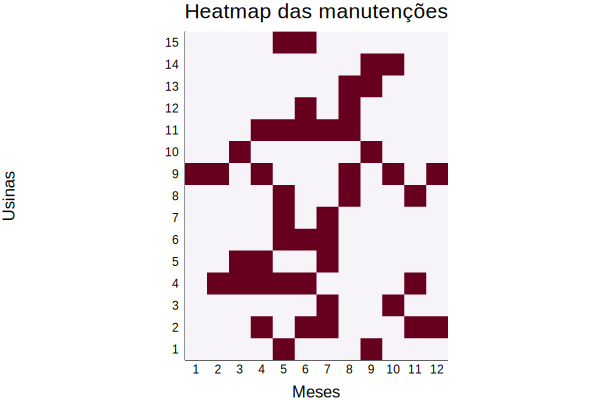

In [11]:
heatmap1

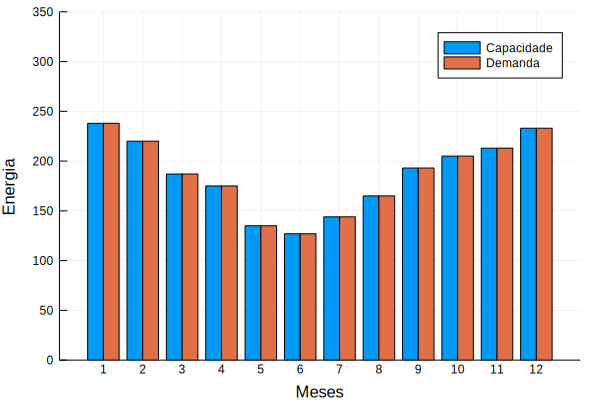

In [12]:
graph1

## 2) Cenários de renováveis e demanda líquida com otimização de valor esperado

<center>$min$ $\sum_s \alpha_s\cdot \frac{1}{N_s}$</center>

<center>$\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t, s$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [13]:
#Quantidade de cenários
S = 10;
#Capacidade de renováveis
R = rand(1:100,12, S);
Dl = D;
for i in 2:S
    Dl = hcat(Dl, D)
end
#Demanda líquida
Dl = Dl-R;

In [14]:
function modelo2(G, Dl)
    T = 12;
    N = length(G);
    S = size(Dl)[2];
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α[1:S])
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T,1:S]
    for j = 1:T
        for k = 1:S
            myCons1[j,k] = @constraint(m, α[k] >= sum(G[i]*(1-x[i,j]) for i=1:N) - Dl[j,k])
        end
    end
    @constraintref myCons2[1:T,1:S]
    for j = 1:T
        for k = 1:S
            myCons2[j,k] = @constraint(m, sum(G[i]*(1-x[i,j]) for i=1:N) >= Dl[j,k])
        end
    end
    @objective(m, Min, sum(α[k] for k=1:S)/S);
    @time status = solve(m)
    return m, getvalue(x)
end

modelo2 (generic function with 1 method)

In [15]:
m2, X2 = modelo2(G, Dl);

  0.228629 seconds (71 allocations: 280.023 KiB)


In [16]:
dados2, heatmap2, graph2 = dados_e_plot(G, X2, Dl, legend = true)
dados2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[13, 14]",223.0
2,2,"[1, 9, 13, 14]",203.0
3,3,"[1, 7, 8, 10, 14]",186.0
4,4,"[2, 4, 5, 8, 9, 14]",167.0
5,5,"[2, 3, 6, 7, 8, 11, 13, 14, 15]",113.0
6,6,"[2, 4, 5, 6, 11, 14, 15]",123.0
7,7,"[1, 4, 5, 12]",165.0
8,8,"[2, 4, 5, 9, 14, 15]",162.0
9,9,"[1, 2, 4, 9, 10, 13]",173.0


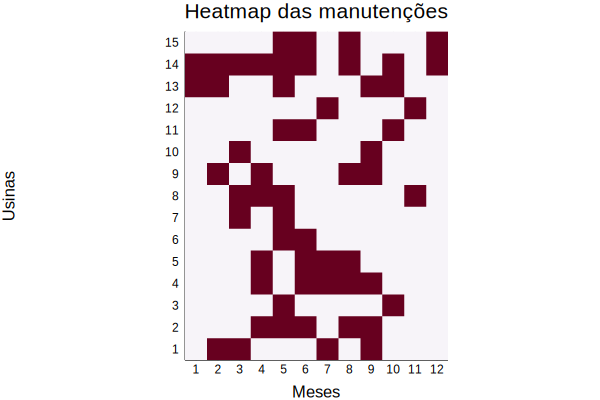

In [17]:
heatmap2

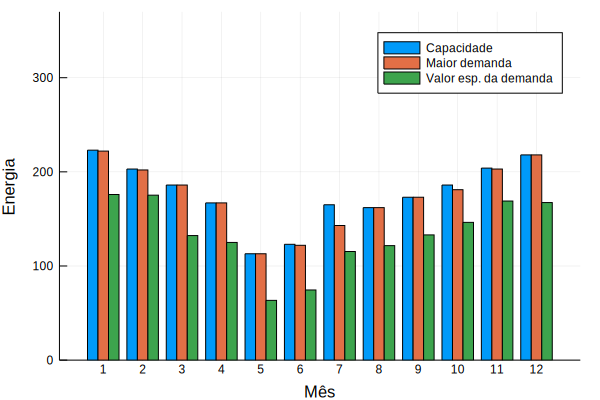

In [18]:
graph2

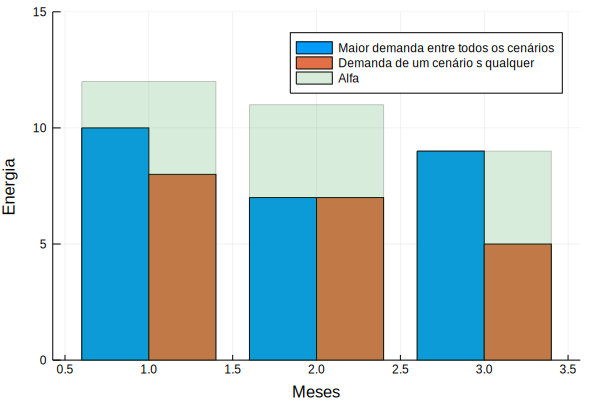

In [19]:
groupedbar([[10, 7, 9] [8, 7, 5]], label = ["Maior demanda entre todos os cenários", "Demanda de um cenário s qualquer"], xaxis = "Meses", yaxis = "Energia", ylims = (0, 15))
bar!([12, 11, 9], alpha = 0.2, label = "Alfa")

## 3) CVaR determinístico nas restrições

<center>$min$ $\alpha$</center>

<center>$\alpha$ $\geq$ $\sum_i Gdisp_i^t-CVaR_\theta(Dliq_t^s)$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [20]:
G3 = G
θ3 = θ
Ns3 = Ns
d3 = Dl
nCVaR3 = Int(floor(θ3 * Ns3))
nplants3 = length(G3)
nmonths3 = size(d3)[1];

In [21]:
CVaR_d3 = zeros(nmonths3)
for month in 1:nmonths3
    CVaR_d3[month] = sum(sort(d3[month, :])[(Ns3 - nCVaR3 + 1):Ns3]) / nCVaR3
end

In [22]:
m3 = Model(solver = CbcSolver())

@variable(m3, x[1:nplants3, 1:nmonths3], Bin)
@variable(m3, α)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m3, sum(x[plant, 1:nmonths3]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths3, 1:Ns3]
for month in 1:nmonths3
    for scenario in 1:Ns3
        constraints2[month, scenario] = @constraint(m3, sum(G3 .* (1 .- x[1:nplants3, month])) >= d3[month, scenario])
    end
end

@constraintref constraints3[1:nmonths3]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m3, α >= sum(G3 .* (1 .- x[1:nplants3, month])) - CVaR_d3[month])
end

@objective(m3, Min, α);

In [23]:
@time solve(m3)
schedule_matrix3 = getvalue(x);

  0.028465 seconds (98 allocations: 170.680 KiB)


In [24]:
dados3, heatmap3, graph3 = dados_e_plot(G3, schedule_matrix3, d3, CVaR = CVaR_d3, legend = true, alpha = 0.3)
dados3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[8, 9]",226.0
2,2,"[1, 8, 9, 13]",204.0
3,3,"[4, 5, 10]",187.0
4,4,"[4, 5, 7, 8, 9]",178.0
5,5,"[2, 4, 6, 7, 8, 11, 12, 13]",113.0
6,6,"[4, 6, 7, 12, 14, 15]",129.0
7,7,"[1, 4, 5, 12, 13]",153.0
8,8,"[5, 9, 11, 13, 14]",173.0
9,9,"[4, 8, 10, 13]",186.0


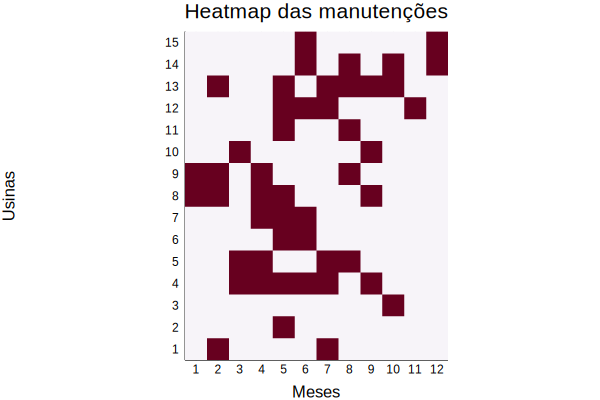

In [25]:
heatmap3

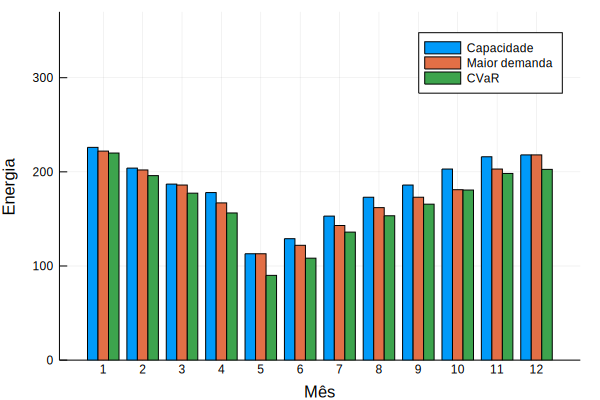

In [26]:
graph3

## 4) CVaR como problema de otimização na função objetivo

<center>$min$ $CVaR_\theta(\alpha)$</center>

<center>$\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

Ou seja:

<center>$min$ $C$</center>

<center>$\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

<center>$C = z - \sum_s p_s \frac{\delta_s}{1-\theta}$</center>

<center>$\delta_s \leq z-\alpha_s$</center>

<center>$\delta_s \leq 0$</center>

In [27]:
G4 = G
d4 = Dl
θ4 = θ

Ns4 = Ns
nplants4 = length(G4)
nmonths4 = size(d4)[1];

In [28]:
m4 = Model(solver = CbcSolver())

@variable(m4, x[1:nplants4, 1:nmonths4], Bin)
@variable(m4, α[1:Ns4])
@variable(m4, z)
@variable(m4, δ[1:Ns4])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants4]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m4, sum(x[plant, 1:nmonths4]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths4, 1:Ns4]
for month in 1:nmonths4
    for scenario in 1:Ns4
        constraints2[month, scenario] = @constraint(m4, sum(G4 .* (1 .- x[1:nplants4, month])) >= d4[month, scenario])
    end
end

@constraintref constraints3[1:nmonths4, 1:Ns4]
for month in 1:nmonths4
    for scenario in 1:Ns4
        constraints3[month, scenario] = @constraint(m4,
            α[scenario] >= sum(G4 .* (1 .- x[1:nplants4, month])) - d4[month, scenario])
    end
end

@constraintref constraints4[1:Ns4]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m4, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns4]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m4, δ[scenario] <= 0)
end

@objective(m4, Min, z - sum(1 / Ns4 * δ[scenario] / (1 - θ4) for scenario in 1:Ns4));

In [29]:
@time solve(m4)
schedule_matrix4 = getvalue(x);

  0.166879 seconds (75 allocations: 285.555 KiB)


In [30]:
dados4, heatmap4, graph4 = dados_e_plot(G4, schedule_matrix4, d4, legend = true)
dados4

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[13, 14]",223.0
2,2,"[1, 9, 13, 14]",203.0
3,3,"[2, 4, 7, 8, 10]",186.0
4,4,"[2, 3, 8, 9, 11, 15]",167.0
5,5,"[2, 5, 6, 8, 11, 12, 13]",115.0
6,6,"[1, 4, 6, 11, 12, 15]",122.0
7,7,"[4, 5, 12, 13]",163.0
8,8,"[2, 3, 6, 7, 8, 9]",162.0
9,9,"[1, 8, 10, 12]",174.0


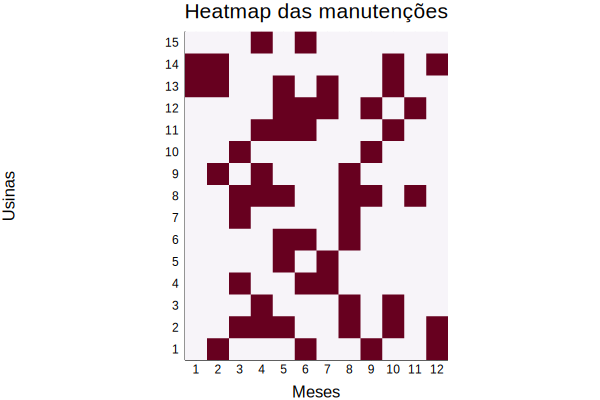

In [31]:
heatmap4

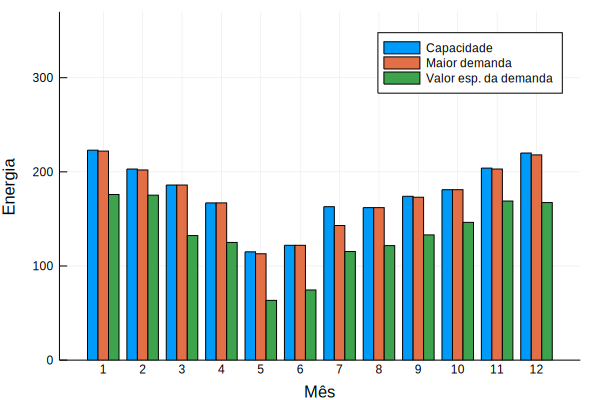

In [32]:
graph4

## Comparação entre o CVaR na restrição e na função objetivo

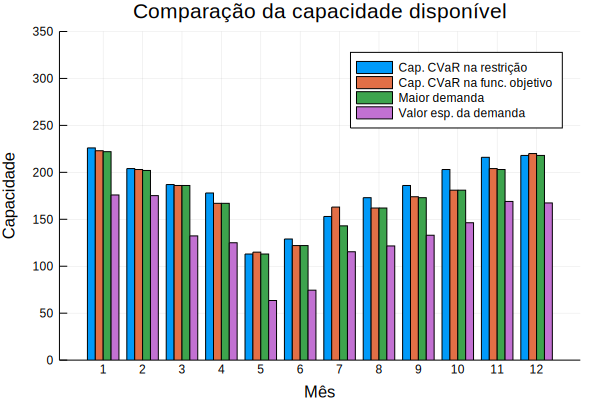

In [33]:
comp3and4 = comparison(Dl, G, dados3, schedule_matrix3, dados4, schedule_matrix4, xlabel1 = "Cap. CVaR na restrição", xlabel2 = "Cap. CVaR na func. objetivo", legend1 = true)
comp3and4[1]

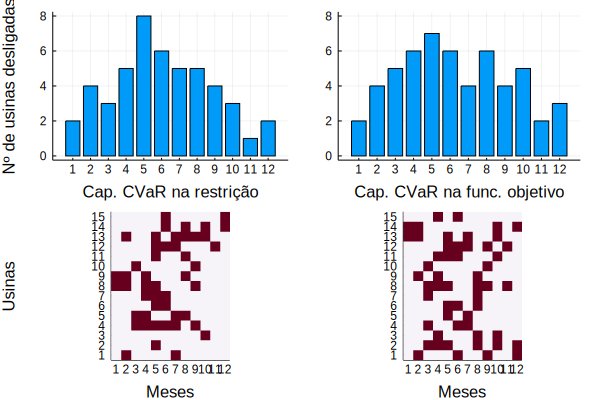

In [34]:
comp3and4[2]

## Comparação entre o CVaR e o valor esperado na função objetivo

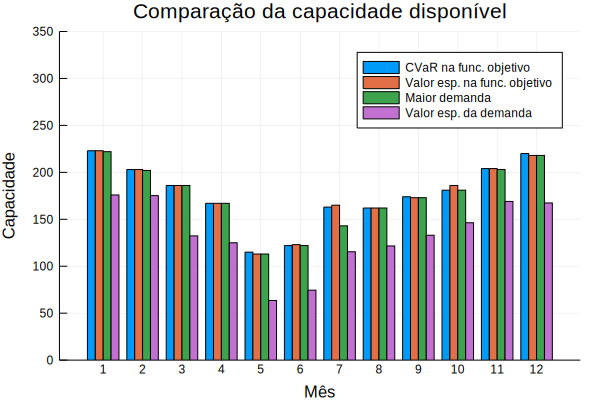

In [35]:
comp4and2 = comparison(Dl, G, dados4, schedule_matrix4, dados2, X2; xlabel1 = "CVaR na func. objetivo",
    xlabel2 = "Valor esp. na func. objetivo",
    legend1 = true)
comp4and2[1]

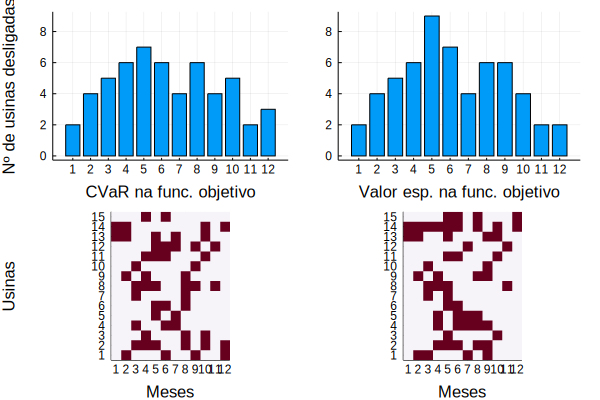

In [36]:
comp4and2[2]

## 5) Combinação convexa de valor esperado e CVaR

<center>$min$ $\lambda \cdot CVaR_\theta(\alpha) + (1-\lambda)\cdot \sum_s \alpha_s\cdot\frac{1}{N_s}$</center>

<center>$\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

Ou seja:

<center>$min$ $\lambda \cdot C + (1-\lambda)\cdot \sum_s \alpha_s\cdot\frac{1}{N_s}$</center>

<center>$\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

<center>$C = z - \sum_s p_s \frac{\delta_s}{1-\theta}$</center>

<center>$\delta_s \leq z-\alpha_s$</center>

<center>$\delta_s \leq 0$</center>

In [37]:
G5 = G
d5 = Dl
θ5 = θ
λ5 = 0.5

Ns5 = Ns
nplants5 = length(G5)
nmonths5 = size(d5)[1];

In [38]:
m5 = Model(solver = CbcSolver())

@variable(m5, x[1:nplants5, 1:nmonths5], Bin)
@variable(m5, α[1:Ns5])
@variable(m5, z)
@variable(m5, δ[1:Ns5])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5, sum(x[plant, 1:nmonths5]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints2[month, scenario] = @constraint(m5, sum(G5 .* (1 .- x[1:nplants5, month])) >= d5[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints3[month, scenario] = @constraint(m5, α[scenario] >= sum(G5 .* (1 .- x[1:nplants5, month])) - d5[month, scenario])
    end
end

@constraintref constraints4[1:Ns5]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m5, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns5]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m5, δ[scenario] <= 0)
end

@expression(m5, CVaR, z - sum(1 / Ns5 * δ[scenario] / (1 - θ5) for scenario in 1:Ns5))
@expression(m5, Eα, sum(α) / Ns5)

@objective(m5, Min, λ5 * CVaR + (1 - λ5) * Eα);

In [39]:
@time solve(m5)
schedule_matrix5 = getvalue(x);

  0.125031 seconds (75 allocations: 285.555 KiB)


In [40]:
dados5, heatmap5, graph5 = dados_e_plot(G5, schedule_matrix5, d5, legend = true)
dados5

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[1, 2, 9]",223.0
2,2,"[1, 9, 13, 14]",203.0
3,3,"[2, 4, 7, 8, 10]",186.0
4,4,"[2, 4, 5, 8, 9, 14]",167.0
5,5,"[2, 6, 7, 8, 10, 11, 13, 14, 15]",113.0
6,6,"[2, 4, 5, 6, 11, 14, 15]",123.0
7,7,"[4, 5, 12, 13]",163.0
8,8,"[4, 5, 6, 14]",162.0
9,9,"[2, 3, 10, 11, 14]",173.0


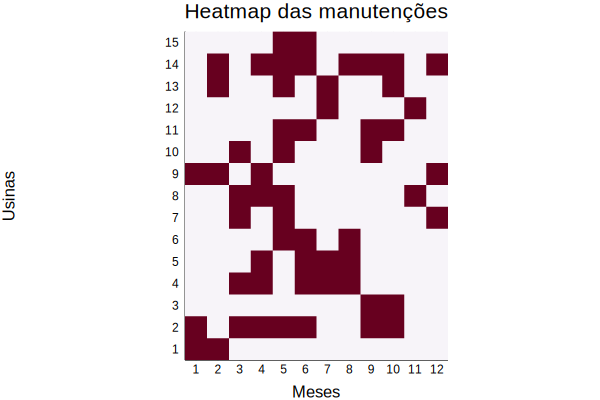

In [41]:
heatmap5

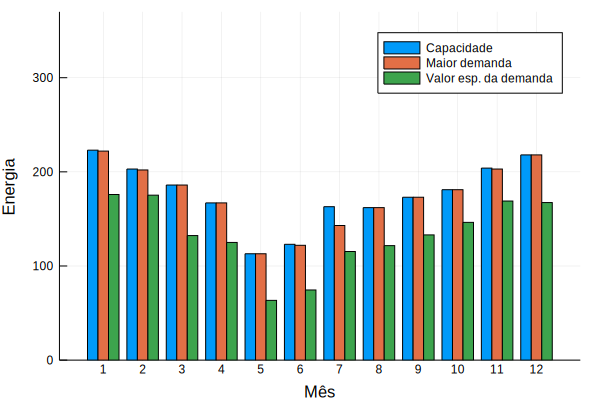

In [42]:
graph5

## 6) Minimizar custo total

<center>$min$ $\sum_t \alpha^t + \sum_{i,t}c_i\cdot g_i^t + \sum_{i,t} k_i \cdot x_i^t$</center>

<center>$\alpha^t$ $\geq$ $\sum_i g_i^t-D_t$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i g_i^t \geq D_t$ $\forall t$</center>

<center>$g_i^t \leq G_i\cdot (1-x_i^t)$</center>

In [43]:
# Custo de geração
c = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15];
# Custo de manutenção
k = [1,1,1,1,1,1,1,1,1,2,2,2,2,1,1];

In [44]:
function modelo6(G, D, c, k)
    T = 12;
    N = length(G);
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α[1:T])
    @variable(m, g[1:N,1:T] >= 0)
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T]
    for j = 1:T
        myCons1[j] = @constraint(m, α[j] >= sum(g[i,j] for i=1:N) - D[j])
    end
    @constraintref myCons2[1:T]
    for j = 1:T
        myCons2[j] = @constraint(m, sum(g[i,j] for i=1:N) >= D[j])
    end
    @constraintref myCons3[1:N,1:T]
    for i = 1:N
        for j = 1:T
            myCons3[i,j] = @constraint(m, g[i,j]<=G[i]*(1-x[i,j]))
        end
    end
    @objective(m, Min, sum(α[j] for j=1:T)+sum(sum(c[i]*g[i,j] for i=1:N) for j=1:T)+sum(sum(k[i]*x[i,j] 
                for j=1:T) for i=1:N));
    @time status = solve(m)
    αa = getvalue(α)
    ga = getvalue(g)
    xa = getvalue(x)
    custo = [αa[j]+sum(c[i]*ga[i,j] for i=1:N)+sum(k[i]*xa[i,j] for i=1:N) for j = 1:T]
    return m, ga, xa, custo
end

modelo6 (generic function with 1 method)

In [45]:
m6, g6, X6, custo6 = modelo6(G,D,c,k);

  0.128040 seconds (66 allocations: 111.758 KiB)


In [46]:
cap = convert(DataFrame, g6)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0
2,5.0,5.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
3,20.0,20.0,20.0,20.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0
4,18.0,18.0,18.0,18.0,18.0,0.0,18.0,18.0,18.0,18.0,18.0,18.0
5,23.0,23.0,23.0,23.0,23.0,23.0,0.0,23.0,23.0,23.0,23.0,23.0
6,32.0,32.0,32.0,32.0,0.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
7,7.0,7.0,7.0,7.0,7.0,7.0,0.0,7.0,7.0,7.0,7.0,7.0
8,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.0,12.0,12.0,12.0
9,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [47]:
dados6, heatmap6, graph6 = dados_e_plot(g6, X6, D, legend = true)
dados6

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],238.0
2,2,[],220.0
3,3,[],187.0
4,4,[10],175.0
5,5,"[6, 9, 13]",135.0
6,6,"[2, 3, 4, 11, 14]",127.0
7,7,"[5, 7, 12]",144.0
8,8,[1],165.0
9,9,[8],193.0


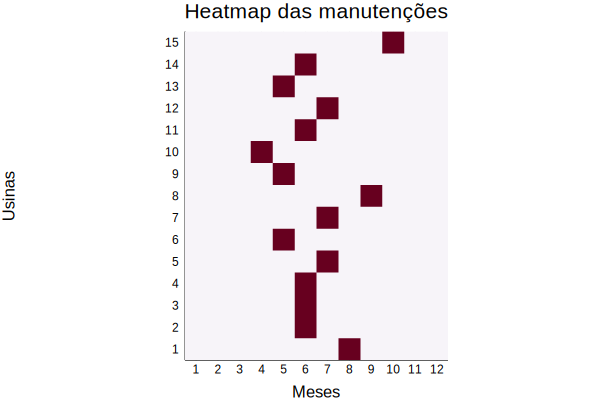

In [48]:
heatmap6

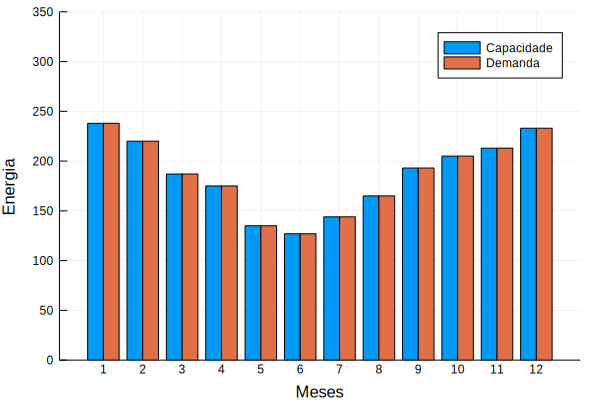

In [49]:
graph6

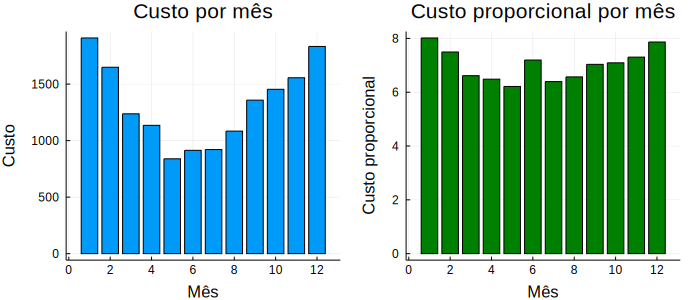

In [50]:
capacidade6 = [sum(g6[:,j]) for j = 1:12]
custo_mensal6 = bar(custo6, legend=false, title = "Custo por mês", xlabel="Mês", ylabel="Custo")
cp6 = [custo6[i]/capacidade6[i] for i in 1:12]
custo_proporcional6 = bar(cp6, legend=false, title = "Custo proporcional por mês", xlabel="Mês", ylabel="Custo proporcional",
    color="green")
plot(custo_mensal6, custo_proporcional6, size=(700, 300))

## 7) Minimizar custo sem $\alpha$

In [51]:
function modelo7(G, D, c, k)
    T = 12;
    N = length(G);
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, g[1:N,1:T] >= 0)
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons2[1:T]
    for j = 1:T
        myCons2[j] = @constraint(m, sum(g[i,j] for i=1:N) >= D[j])
    end
    @constraintref myCons3[1:N,1:T]
    for i = 1:N
        for j = 1:T
            myCons3[i,j] = @constraint(m, g[i,j]<=G[i]*(1-x[i,j]))
        end
    end
    @objective(m, Min, sum(sum(c[i]*g[i,j] for i=1:N) for j=1:T)+sum(sum(k[i]*x[i,j] 
                for j=1:T) for i=1:N));
    @time status = solve(m)
    ga = getvalue(g)
    xa = getvalue(x)
    custo = [sum(c[i]*ga[i,j] for i=1:N)+sum(k[i]*xa[i,j] for i=1:N) for j = 1:T]
    return m, ga, xa, custo
end

modelo7 (generic function with 1 method)

In [52]:
m7, g7, X7, custo7 = modelo7(G,D,c,k);

  0.059538 seconds (66 allocations: 97.445 KiB)


In [53]:
dados7, heatmap7, graph7 = dados_e_plot(g7, X7, D, legend = true);

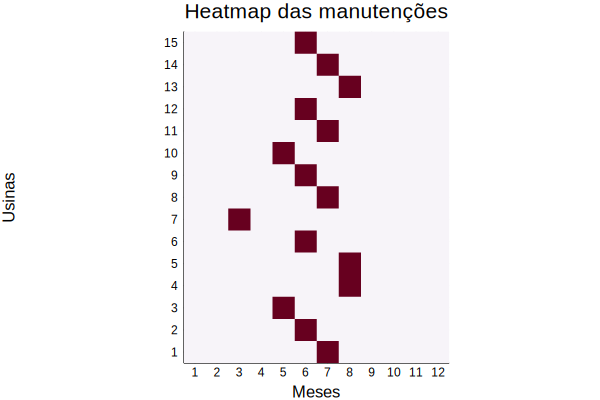

In [54]:
heatmap7

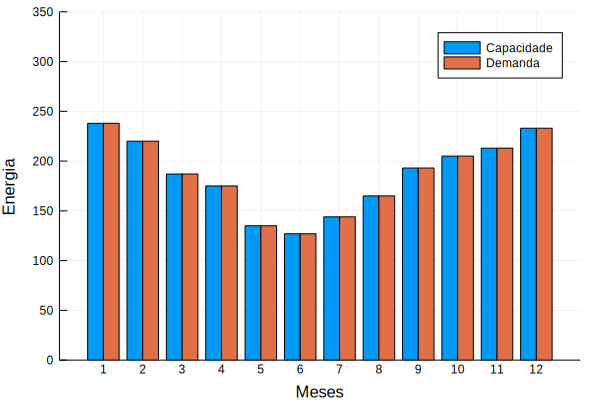

In [55]:
graph7

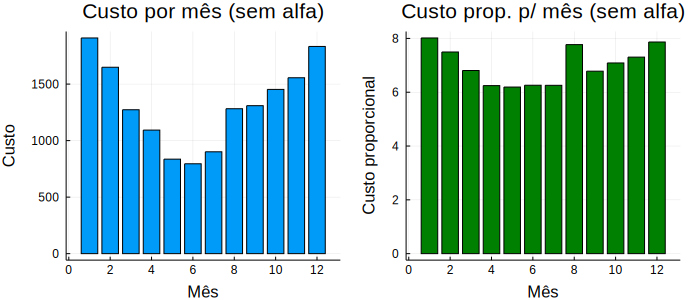

In [56]:
capacidade7 = [sum(g7[:,j]) for j = 1:12]
custo_mensal7 = bar(custo7, legend=false, title = "Custo por mês (sem alfa)", xlabel="Mês", ylabel="Custo")
cp7 = [custo7[i]/capacidade7[i] for i in 1:12]
custo_proporcional7 = bar(cp7, legend=false, title = "Custo prop. p/ mês (sem alfa)", xlabel="Mês", ylabel="Custo proporcional",
    color="green")
plot(custo_mensal7, custo_proporcional7, size=(700, 300))

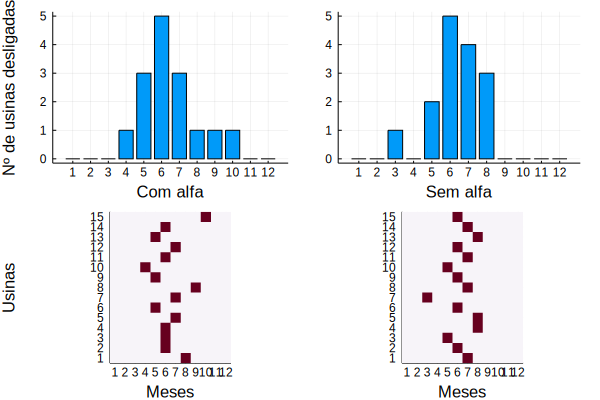

In [57]:
comparison(D, G, dados6, X6, dados7, X7; xlabel1 = "Com alfa", xlabel2 = "Sem alfa")[2]

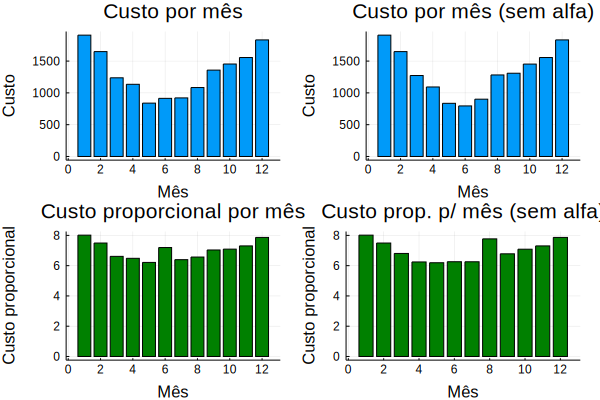

In [58]:
plot(custo_mensal6, custo_mensal7, custo_proporcional6, custo_proporcional7, layout = (2, 2))

## PSR maintenance scheduling model

In [59]:
#Complete model

#=N_t = 12
#José Batlle y Ordóñez (1), Punta del Tigre (1), La Tablada (2), Maldonado (1)
g_j = hcat([[394, 300, 285, 24] for i in 1:N_t]...)
#Salto Grande Dam (7), Constitución (El Palmar) Dam (3), Gabriel Terra (Rincón del Bonete) Dam (4), Baygorria Dam (3)
g_h = hcat([[1890, 333, 160, 108] for i in 1:N_t]...)
u_j = [1, 1, 2, 1]
u_h = [7, 3, 4, 3]
ψ_j = Int.(zeros(size(g_j)[1], N_t))
ψ_h = Int.(zeros(size(g_h)[1], N_t))
N_S = 10
r = zeros(2, N_S, N_t)
for s in 1:N_S
    for t in 1:N_t
        r[:, s, t] = [0, 0]
    end
end
d = Int.(round.(2494 .* [0.92, 0.93, 0.86, 0.87, 0.89, 1, 0.94, 0.96, 0.97, 0.89, 0.9, 0.91]))
d_s = zeros(N_S, N_t)
for s in 1:N_S
    for t in 1:N_t
        d_s[s, t] = d[t] - sum(r[:, s, t])
    end
end
β = 0.1
λ = 0.7
k = 1

m = Model(solver = CbcSolver())

@variables m begin
    α_j[j = 1:size(g_j)[1], u = 1:u_j[j], t = 1:N_t], Bin
    α_h[h = 1:size(g_h)[1], u = 1:u_h[h], t = 1:N_t], Bin
    δ_s[1:N_S]
    z
    μ_s[1:N_S] <= 0
end

@constraintref reserve[1:N_t, 1:N_S]
for t in 1:N_t
    for s in 1:N_S
        reserve[t, s] = @constraint(m, δ_s[s] <= 1 / d[t] * 
            (sum(sum((1 - ψ_h[h, t]) * g_h[h, t] / u_h[h] * α_h[h, u, t] for u in 1:u_h[h]) for h in 1:size(g_h)[1])
                + sum(sum((1 - ψ_j[j, t]) * g_j[j, t] / u_j[j] * α_j[j, u, t] for u in 1:u_j[j]) for j in 1:size(g_j)[1]) - d_s[s, t]))
    end
end

@constraintref CVaR[1:N_S]
for s in 1:N_S
    CVaR[s] = @constraint(m, μ_s[s] + z <= δ_s[s])
end

@constraintref units_h[1:size(g_h)[1], 1:sort(u_h)[end]]
for h in 1:size(g_h)[1]
    for u in 1:u_h[h]
        units_h[h, u] = @constraint(m, sum(α_h[h, u, t] for t in 1:N_t) == N_t - k)
    end
end

@constraintref units_j[1:size(g_j)[1], 1:sort(u_j)[end]]
for j in 1:size(g_j)[1]
    for u in 1:u_j[j]
        units_j[j, u] = @constraint(m, sum(α_j[j, u, t] for t in 1:N_t) == N_t - k)
    end
end

@expression(m, CVaR_β, z + 1 / N_S * 1 / (1 - β) * sum(μ_s))

@objective(m, Max, λ * CVaR_β + (1 - λ) * 1 / N_S * sum(δ_s))

@time solve(m);=#

In [89]:
N_t = 12
g_h = G
N_S = 10
r = zeros(1, N_S, N_t)
dt = D
#=for s in 1:N_S
    for t in 1:N_t
        r[:, s, t] = [0.3 * dt[t] * rand()]
    end
end
d_s = zeros(N_S, N_t)
for s in 1:N_S
    for t in 1:N_t
        d_s[s, t] = dt[t] - sum(r[:, s, t])
    end
end=#
d_s = Dl'
β = 0.2
λ = 0.5
k = 1;

In [90]:
m8 = Model(solver = CbcSolver())

@variables m8 begin
    α_h[1:length(g_h), 1:N_t], Bin
    δ_s[1:N_S]
    z
    μ_s[1:N_S] <= 0
end

@constraintref reserve[1:N_t, 1:N_S]
for t in 1:N_t
    for s in 1:N_S
        reserve[t, s] = @constraint(m8, δ_s[s] <= 1 / dt[t] * 
            (sum(g_h[h] * (1 - α_h[h, t]) for h in 1:length(g_h)) - d_s[s, t]))
    end
end

@constraintref CVaR[1:N_S]
for s in 1:N_S
    CVaR[s] = @constraint(m8, μ_s[s] + z <= δ_s[s])
end

@constraintref plants_h[1:length(g_h)]
for h in 1:length(g_h)
    plants_h[h] = @constraint(m8, sum((1 - α_h[h, t]) for t in 1:N_t) == N_t - k)
end

@expression(m8, CVaR_β, z + 1 / N_S * 1 / (1 - β) * sum(μ_s))

@objective(m8, Max, λ * CVaR_β + (1 - λ) * 1 / N_S * sum(δ_s));

In [91]:
@time solve(m8)
schedule_matrix8 = getvalue(α_h);

  0.023751 seconds (75 allocations: 168.180 KiB)


In [92]:
dados8, heatmap8, graph8 = dados_e_plot(g_h, schedule_matrix8, d_s', legend = true)
dados8

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],248.0
2,2,[],248.0
3,3,"[7, 13]",229.0
4,4,[5],225.0
5,5,"[2, 8, 10, 11, 12]",162.0
6,6,"[6, 9, 14, 15]",176.0
7,7,"[1, 3, 4]",200.0
8,8,[],248.0
9,9,[],248.0


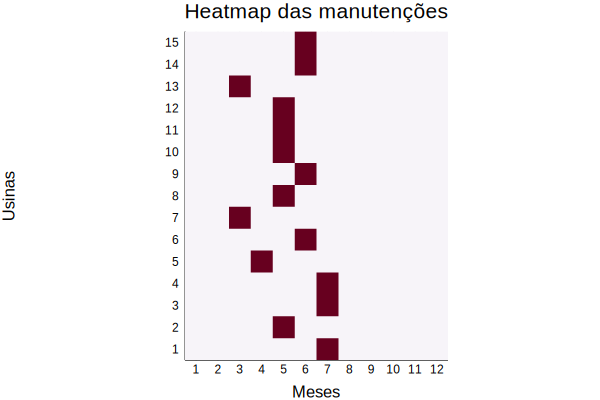

In [93]:
heatmap8

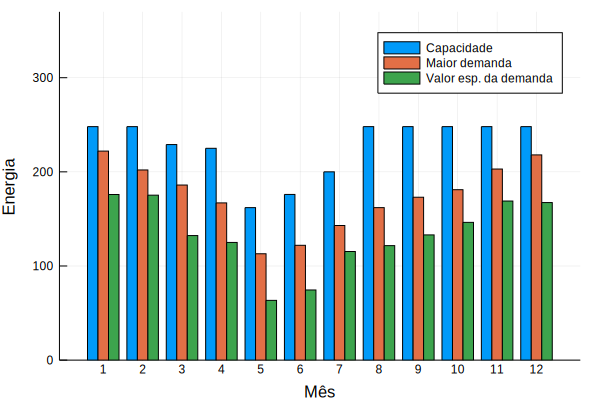

In [94]:
graph8

## Comparação entre o PSR maintenance scheduling model e a otimização de valor esperado

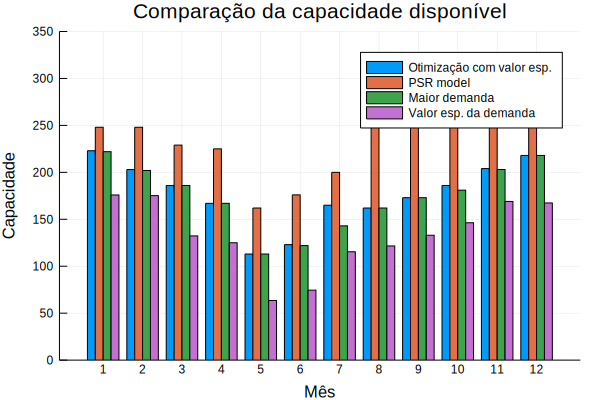

In [95]:
comp2and8 = comparison(Dl, G, dados2, X2, dados8, schedule_matrix8, xlabel1 = "Otimização com valor esp.", xlabel2 = "PSR model", legend1 = true)
comp2and8[1]

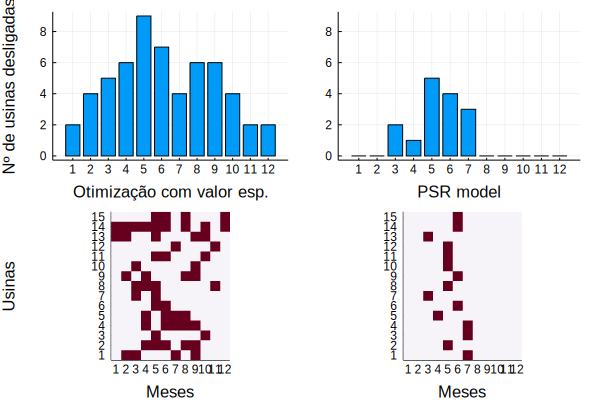

In [96]:
comp2and8[2]

## Comparação entre o PSR maintenance scheduling model e o CVaR na função objetivo

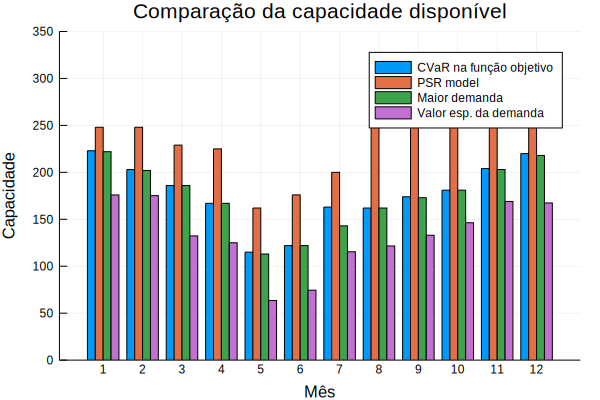

In [102]:
comp4and8 = comparison(Dl, G, dados4, schedule_matrix4, dados8, schedule_matrix8, xlabel1 = "CVaR na função objetivo", xlabel2 = "PSR model", legend1 = true)
comp4and8[1]

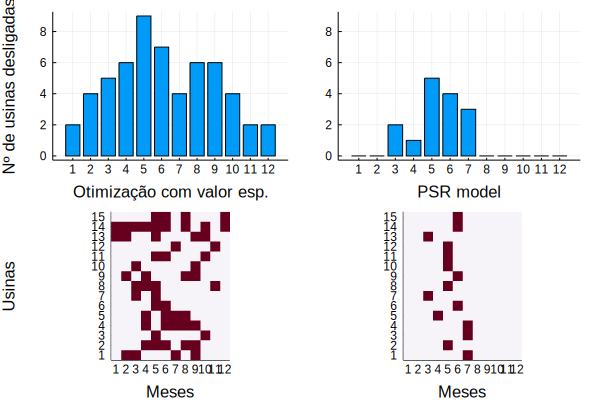

In [103]:
comp2and8[2]

## Comparação entre o PSR maintenance scheduling model e a combinação convexa (CVaR e valor esperado)

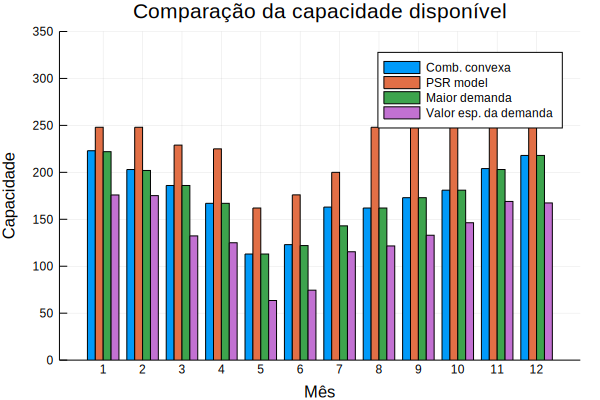

In [105]:
comp5and8 = comparison(Dl, G, dados5, schedule_matrix5, dados8, schedule_matrix8, xlabel1 = "Comb. convexa", xlabel2 = "PSR model", legend1 = true)
comp5and8[1]

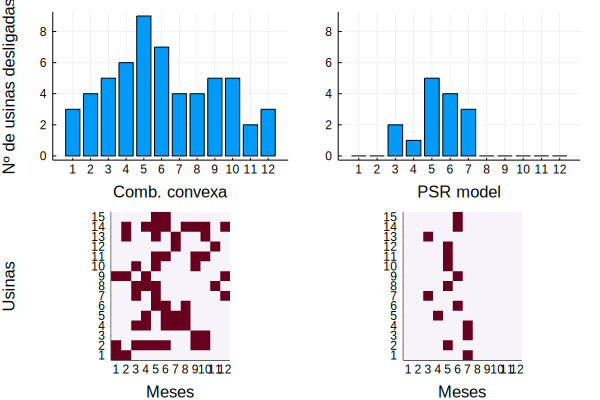

In [106]:
comp5and8[2]